### Importing Libraries


In [ ]:
from matplotlib import pyplot as plt  
from skimage.io import imread         
import numpy as np                    
import datetime                       
import math                           
import os                             

from tensorflow.keras.utils import to_categorical, Sequence
import tensorflow as tf
import keras

### Data Loading


In [ ]:
img_dir = '../input/artificial-lunar-rocky-landscape-dataset/images/render'
mask_dir = '../input/artificial-lunar-rocky-landscape-dataset/images/clean'

# Sorting the files in root directories, Creating and Storing the complete image and mask paths
images = [os.path.join(img_dir, x) for x in sorted(os.listdir(img_dir))]
masks = [os.path.join(mask_dir, x) for x in sorted(os.listdir(mask_dir))]

# First 8000 images to be used for training
X_train = images[:8000]
y_train = masks[:8000]

# Remaining to be used for validation purpose
X_valid = images[8000:-4]
y_valid = masks[8000:-4]

# Saving some for testing purpose (last 4)
X_test = images[-4:]
y_test = masks[-4:]


### Dataset Pipeline


In [ ]:
class LunarDataset(Sequence):

    # Creating A Constructor
    def __init__(self, x_set, y_set, batch_size, dims, classes):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.img_height, self.img_width = dims
        self.classes = classes

    # Number of Batches
    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    # Fetching the data in batches by using iter and next opertions
    def __getitem__(self, idx):
        # Getting start and end indexes to create a batch of batch size
        start_index = idx * self.batch_size
        end_index = (idx + 1) * self.batch_size

        # Preparing X and y batches
        batch_x = self.x[start_index : end_index]
        batch_y = self.y[start_index : end_index]

        # Creating Empty lists to append preprocessed Images and Masks Array from the for loop
        xtr = []
        ytr = []

        # For every image and mask in one batch, the following preprocessing is done
        for idx, (filename_x, filename_y) in enumerate(zip(batch_x, batch_y)):

            # Image preprocessing
            img = imread(filename_x)[:self.img_height, :self.img_width, :] / 255.0                           # Read, Slice to dims and Normalize
            img = img.astype(np.float32)                                                                     # Ensure dtype is float32
            xtr.append(img)                                                                                  # Append the image to the xtr list

            # Mask preprocessing
            mask = imread(filename_y, as_gray=True)[:self.img_height, :self.img_width] // 0.07               # Read, Slice, Format
            mask[mask == 3] = 2                                                                              # Convert the pixels that read as 3 to 2
            mask[mask == 10] = 3                                                                             # Convert the pixels that read as 10 to 3
            mask = to_categorical(mask, num_classes=self.classes)                                            # Apply One Hot encoding and create 4 channels
            ytr.append(mask)                                                                                 # Append the mask to the ytr list

        # Converting list to arrays ensuring the dtype of mask is also float32
        xtr = np.array(xtr)
        ytr = np.array(ytr).astype(np.float32)

        # Returning the preprocessed batch of images and respective mask as output
        return xtr, ytr

### Dataset Creation


In [ ]:
# Parameters
batch_size = 16
dims = (480, 480)
num_classes = 4

# Dataset Creation
train_dataset = LunarDataset(X_train, y_train, batch_size, dims, num_classes)
valid_dataset = LunarDataset(X_valid, y_valid, batch_size, dims, num_classes)

### Mask Visualization


In [ ]:
# Taking a sample batch from train_dataset
batch = next(iter(train_dataset)) # Batch Size, Height, Width, Channels (Images, Masks)

# Check the shape of batch created --> Images and Masks
print(batch[0].shape) # 16 images in a batch
print(batch[1].shape) # 16 respective masks in a batch

(16, 480, 480, 3)

(16, 480, 480, 4)


In [ ]:
# Get the mask
sample = batch[1][1] # Second in the batch

### Visualizing the Dataset


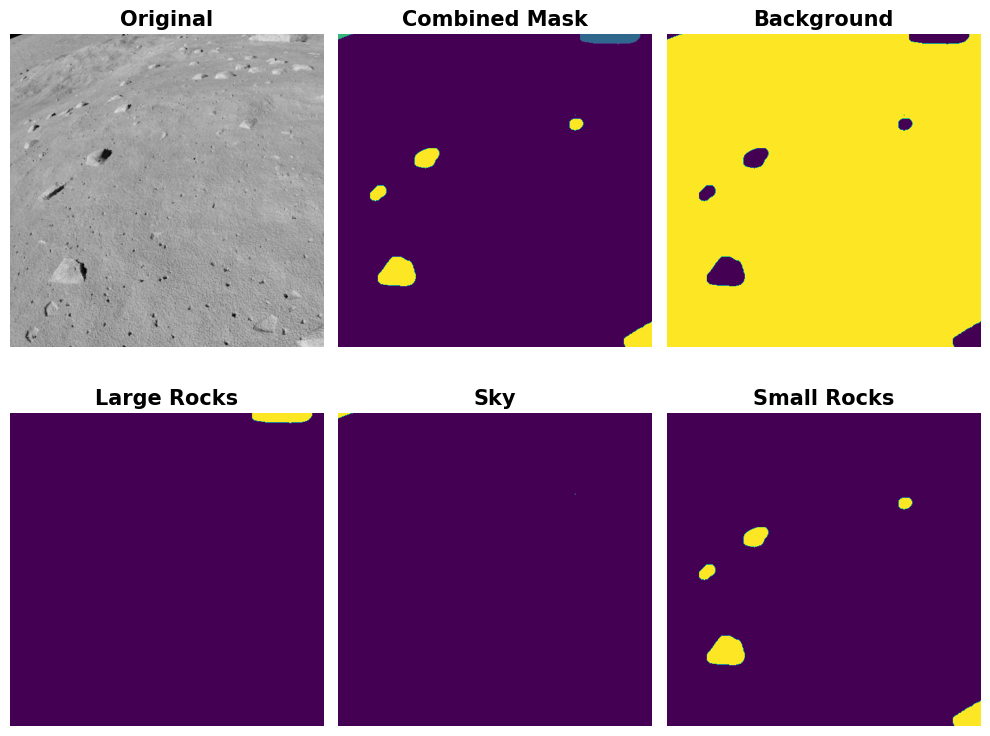

In [ ]:
# Creating Subplot for better visualization
fig, ((a1, a2, a3), (a4, a5, a6)) = plt.subplots(2, 3, figsize = (10, 8))

# For different axes and titles
for i, (ax,title) in enumerate(zip((a1, a2, a3, a4, a5, a6),
                                   ('Original', 'Combined Mask', 'Background', 'Large Rocks', 'Sky', 'Small Rocks'))):
    if i == 0:
        ax.imshow(batch[0][1])                    # Second Image in the batch (Original)
    elif i == 1:
        ax.imshow(np.argmax(sample, axis=-1))     # Converts One Hot encoded mask to Integer Encoded Mask (single channel)
    else:
        ax.imshow(sample[:, :, i-2])              # Channel Wise Output from Mask

    # Set Title and turn off the axis
    ax.set_title(title, fontsize=15, weight='bold')
    ax.axis('off')

# Adjust Layout and Display the Subplot
plt.tight_layout()
plt.show()

In [1]:
#USING SEGMENTATION MODELS LIBRARY:

!pip install segmentation_models

  Using cached segmentation_models-1.0.1-py3-none-any.whl (33 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached image_classifiers-1.0.0-py3-none-any.whl (19 kB)
  Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)
  Using cached h5py-3.10.0-cp312-cp312-win_amd64.whl.metadata (2.5 kB)
Using cached h5py-3.10.0-cp312-cp312-win_amd64.whl (2.7 MB)


In [ ]:
# By default it tries to import keras, if it is not installed, it will try to start with tensorflow.keras framework

os.environ["SM_FRAMEWORK"] = "tf.keras"           # Setting the environment variable SM_FRAMEWORK to "tf.keras"
import segmentation_models as sm                  # It will import without any errors if env variable is set properly
sm.set_framework('tf.keras')                      # Using segmentation_models library and setting the framework to TensorFlow's Keras

Segmentation Models: using `tf.keras` framework.


In [ ]:
# Setting the last axis of the tensor as channel axis
tf.keras.backend.set_image_data_format('channels_last')
# Explicitly setting this is not always necessary, as 'channels_last' is the default setting

### UNet Model with VGG16 Backbone


In [ ]:
# Parameters
BACKBONE = 'vgg16'
input_shape = (480, 480, 3)
n_classes = 4
activation = 'softmax'


model = sm.Unet(backbone_name = BACKBONE,
                input_shape = input_shape,
                classes = n_classes,
                activation = activation,
                encoder_weights = 'imagenet',
                encoder_freeze = True)


# Checking the model summary
model.summary()


58889256/58889256 [==============================] - 1s 0us/step

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 480, 480, 3)]        0         []                            

                                                                                                  

 block1_conv1 (Conv2D)       (None, 480, 480, 64)         1792      ['input_1[0][0]']             

                                                                                                  

 block1_conv2 (Conv2D)       (None, 480, 480, 64)         36928     ['block1_conv1[0][0]']        

                                                                                                  

 block1_pool (MaxPooling2D)  (None, 240, 240, 64)         0         ['block1_conv2[0][0]']        

                

### Model Compilation


In [ ]:
#Hyperparameters
lr = 1e-3
batch_size = 32
epochs = 5

# Setting metrics for result validation
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# Compiling
model.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(lr),
                metrics = metrics)

# Setting steps per epoch (training in batches)
train_steps = len(X_train)//batch_size
valid_steps = len(X_valid)//batch_size


# Getting the current datetime to use later in the name of files
current_datetime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Setting callbacks below
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'models/lunarModel_{current_datetime}.h5',
            monitor='val_iou_score', verbose=0,
            mode='max',
            save_best_model=True
        ),

        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_iou_score",
            mode='max',
            patience=2,
            factor=0.1,
            verbose=0,
            min_lr=1e-6
        ),

        tf.keras.callbacks.EarlyStopping(
            monitor="val_iou_score",
            patience=3,
            verbose=0,
            mode='max'
        )
    ]

In [ ]:
model_history = model.fit(train_dataset,
                            steps_per_epoch=train_steps,
                            validation_data=valid_dataset,
                            validation_steps=valid_steps,
                            epochs=epochs,
                            callbacks=callbacks
    )

Epoch 1/5

250/250 [==============================] - 248s 965ms/step - loss: 0.1073 - iou_score: 0.7653 - f1-score: 0.8486 - val_loss: 0.1080 - val_iou_score: 0.7522 - val_f1-score: 0.8365 - lr: 0.0010

Epoch 2/5

250/250 [==============================] - 242s 965ms/step - loss: 0.1052 - iou_score: 0.7669 - f1-score: 0.8496 - val_loss: 0.1148 - val_iou_score: 0.7474 - val_f1-score: 0.8321 - lr: 0.0010

Epoch 3/5

250/250 [==============================] - 242s 965ms/step - loss: 0.1017 - iou_score: 0.7787 - f1-score: 0.8594 - val_loss: 0.1201 - val_iou_score: 0.7351 - val_f1-score: 0.8187 - lr: 0.0010

Epoch 4/5

250/250 [==============================] - 242s 967ms/step - loss: 0.0959 - iou_score: 0.7908 - f1-score: 0.8686 - val_loss: 0.0982 - val_iou_score: 0.7715 - val_f1-score: 0.8520 - lr: 1.0000e-04

Epoch 5/5

250/250 [==============================] - 241s 964ms/step - loss: 0.0929 - iou_score: 0.8002 - f1-score: 0.8762 - val_loss: 0.0969 - val_iou_score: 0.7692 - val_f1-scor

### Model Prediction


In [ ]:
# function to predict result
def predict_image(img_path, mask_path, model):
    H = 480
    W = 480
    num_classes = 4

    img = imread(img_path)
    img = img[:480, :480, :]
    img = img / 255.0
    img = img.astype(np.float32)

    ## Read mask
    mask = imread(mask_path, as_gray = True)
    mask = mask[:480, :480]

    ## Prediction
    pred_mask = model.predict(np.expand_dims(img, axis=0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]


    # calculating IOU score
    inter = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)

    iou = inter.sum() / union.sum()

    return img, mask, pred_mask, iou

1/1 [==============================] - 0s 23ms/step


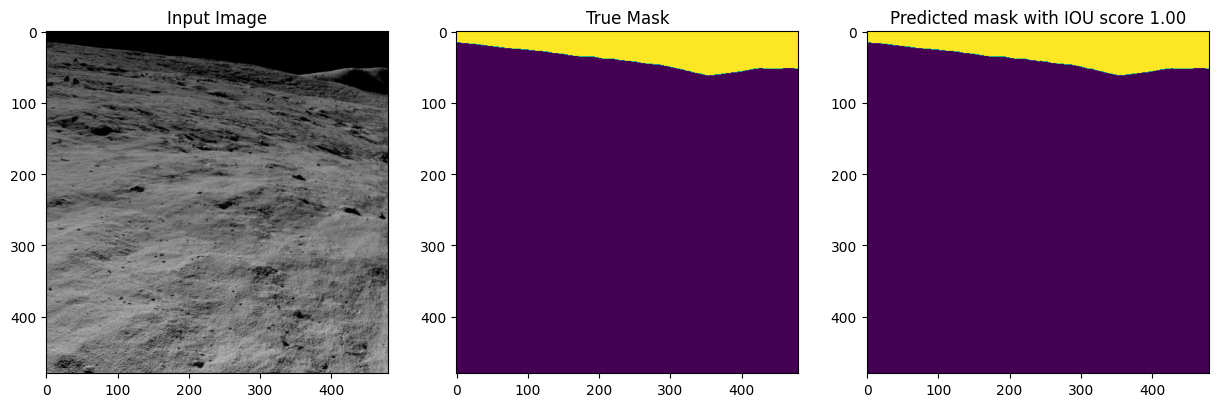

In [ ]:
#RANDOMLY CHOOSING A COMBINATION OF IMAGE-MASK:

img_path = f'../input/artificial-lunar-rocky-landscape-dataset/images/render/render0050.png'
mask_path = f'../input/artificial-lunar-rocky-landscape-dataset/images/clean/clean0050.png'

img, mask, pred_mask, iou = predict_image(img_path, mask_path, model)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 10))

ax1.set_title("Input Image")
ax1.imshow(img)

ax2.set_title("True Mask")
ax2.imshow(mask)

ax3.set_title("Predicted mask with IOU score %.2f"%(iou))
ax3.imshow(pred_mask)

plt.show()

### Project Result


In [ ]:
'''
IMAGE SIZE      BATCH SIZE	    LEARNING RATE	    EPOCHS	    LOSS FUNCTION	    DATA AUGMENTATION & FINE TUNING	    MAX IOU SCORE ACHIEVED	    MAX VALIDATION IOU SCORE ACHIEVED
480	                16	            1e-5	            8	    CategoricalCrossEntropy	    Not Applied	                        0.68	                        0.64
256	                16	            1e-5	            5	    JaccardLoss	                Not Applied	                        0.74	                        0.70
256	                32	            1e-3	            5	    JaccardLoss	                Not Applied	                        0.73	                        0.73
256	                32	            1e-3	            7	    JaccardLoss	                Not Applied	                        0.65	                        0.63
256	                16	            1e-4	            5	    JaccardLoss	                Applied*	                        0.57	                        0.60
480	                32	            1e-3	            8	    JaccardLoss	                Not Applied	                        0.72	                        0.68
480	                32	            1e-3	            5	    CategoricalCrossEntropy	    Not Applied	                        0.80	                        0.76
256	                64	            1e-6	            6	    CategoricalCrossEntropy	    Not Applied	                        0.71	                        0.62
480	                64	            1e-6	            6	    JaccardLoss	                Not Applied	                        0.56	                        0.52

Other combinations were attempted, yet the highest IOU score was achieved by maintaining image cropping size at (480, 480), batch size at 32, learning rate at 1e-3, epochs at 5, and using Categorical Cross Entropy loss function without any data augmentation or fine-tuning
'''